# Tratamiento de datos COVID-10
## Objeto
Se tratarán los datos de la [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19) que se traem al directorio $data_dir. 

Se utilizarán tablas de población para, en el futuro, obtener información más relevante

## Obtención de datos
Se obtienen los datos de población desde los repositorios de Naciones Unidas.
Los datos de contagios y fallecidos por COVID-19 se traen del repositorio mantenido por la Universidad Johns Hopkins, 
los de vacunaciones, de Our World In Data, los de medidas, del Centro Europeo para la Prevención y el Control de Enfermedades 
(una agencia de la UE),

In [116]:
data_dir = './data'
covid_dir = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series'
covid_git_url = 'https://github.com/CSSEGISandData/COVID-19'
population_file = 'WPP2019_PopulationByAgeSex_Medium.csv'
covid_confirmed_file = 'time_series_covid19_confirmed_global.csv'
covid_deaths_file = 'time_series_covid19_deaths_global.csv'
un_pop_repo_url = 'https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/' + population_file
covid_owid_dir = 'covid-19-data'
covid_owid_url = 'https://github.com/owid/covid-19-data.git'
covid_owid_vaccinations_file = 'public/data/vaccinations/vaccinations.csv'
measures_file = 'measures.csv'

! if [ ! -d '{data_dir}' ]; then echo 'No existe directorio de datos. Creándolo...'; mkdir '{data_dir}' ; fi
! if [ ! -d '{data_dir}/{covid_dir}' ]; then echo 'No existe clone del repositorio {covid_dir}. Ejecutando git clone {covid_git_url}'; cd '{data_dir}';  git clone '{covid_git_url}'; fi
! if [ ! -d "{data_dir}/{covid_owid_dir}" ]; then echo 'No existe clone del repositorio {covid_owid_dir}. Ejecutando git clone {covid_owid_url}'; cd '{data_dir}';  git clone '{covid_owid_url}'; fi
! if [ ! -f '{data_dir}/{population_file}' ]; then echo 'No existen datos de población Trayéndolos de {un_pop_repo_url}'; cd '{data_dir}'; curl -g '{un_pop_repo_url}' -o $population_file; fi

### Datos de población

In [117]:
! ls -l '{data_dir}/{population_file}'

-rw-r--r-- 1 10001 10001 118543941 Feb  7 05:26 ./data/WPP2019_PopulationByAgeSex_Medium.csv


### Datos de la Johns Hopkins

In [118]:
! cd '{data_dir}/{covid_dir}'; git pull
! ls -l '{data_dir}/{covid_dir}/'

remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 26 (delta 19), reused 21 (delta 19), pack-reused 5
Unpacking objects: 100% (26/26), 325.14 KiB | 443.00 KiB/s, done.
From https://github.com/CSSEGISandData/COVID-19
   965479418..61ad34573  master     -> origin/master
   f0b61822b..7f74101bf  web-data   -> origin/web-data
Updating 965479418..61ad34573
Fast-forward
 .../csse_covid_19_daily_reports/02-21-2021.csv     | 3981 ++++++++++++
 .../csse_covid_19_daily_reports_us/02-21-2021.csv  |   59 +
 .../time_series_covid19_confirmed_US.csv           | 6682 ++++++++++----------
 .../time_series_covid19_confirmed_global.csv       |  548 +-
 .../time_series_covid19_deaths_US.csv              | 6682 ++++++++++----------
 .../time_series_covid19_deaths_global.csv          |  548 +-
 .../time_series_covid19_recovered_global.csv       |  518 +-
 7 files changed, 11529 insertions(+), 7489 deletions(-)
 c

### Datos de Our World In Data 

In [119]:
! cd '{data_dir}/{covid_owid_dir}'; git pull
! ls -l '{data_dir}/{covid_owid_dir}/{covid_owid_vaccinations_file}'

remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 51 (delta 38), reused 39 (delta 38), pack-reused 11
Unpacking objects: 100% (51/51), 10.86 MiB | 1.49 MiB/s, done.
From https://github.com/owid/covid-19-data
   5a1778502..e04e57a06  master     -> origin/master
Updating 5a1778502..e04e57a06
Fast-forward
 .../jhu/COVID-19 - Johns Hopkins University.csv    | 209 +++++++-
 public/data/jhu/biweekly_cases.csv                 |   3 +-
 public/data/jhu/biweekly_cases_per_million.csv     |   3 +-
 public/data/jhu/biweekly_deaths.csv                |   1 +
 public/data/jhu/biweekly_deaths_per_million.csv    |   1 +
 public/data/jhu/full_data.csv                      | 201 +++++++-
 public/data/jhu/new_cases.csv                      |   1 +
 public/data/jhu/new_cases_per_million.csv          |   1 +
 public/data/jhu/new_deaths.csv                     |   1 +
 public/data/jhu/new_deaths_per_million.csv 

### Datos de medidas tomadas

In [120]:
! curl 'https://www.ecdc.europa.eu/sites/default/files/documents/response_graphs_data_2021-01-28.csv' >> $data_dir/$measures_file
! ls -l $data_dir/$measures_file

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (7) Couldn't connect to server
-rw-r--r-- 1 10001 10001 2864858 Feb 22 04:56 ./data/measures.csv


### Importación de datos
Lo primero es común a todos los programas que traten datos

In [121]:
%matplotlib inline
import pandas as pd
import numpy as np

Se utiliza Pandas para leer el fichero csv. Las columnas que notienen datos (las 4 primeras), se ponen de índice. 

Se van a leer los datos de fallecimientos, casos confirmados, población y vacunaciones.

Los datos de medidas, hasta que no se optimice el procedimiento, se obtienen después

In [122]:
deaths = pd.read_csv(data_dir + '/' + covid_dir + '/' + covid_deaths_file, 
                      index_col=[0,1,2,3])
confirmed = pd.read_csv(data_dir + '/' + covid_dir + '/' + covid_confirmed_file, 
                           index_col=[0,1,2,3])
population = pd.read_csv (data_dir + '/' + population_file)
vaccinations = pd.read_csv (data_dir + '/' + covid_owid_dir + '/' + covid_owid_vaccinations_file, 
                            usecols=['location', 'date',
                                     'people_vaccinated_per_hundred',
                                     'people_fully_vaccinated_per_hundred'], 
                            parse_dates=['date'])


## Tratamiento de datos
Se filtran los datos de población para suprimir la división por edades y quedarnos con los del año 2021. 
Se conserva la división por género por si tuviese interés

In [123]:
pop_filtered = population[(population['VarID'] == 2) & (population['Time'] == 2021) ] \
                         [['Location','PopMale','PopFemale','PopTotal']] \
                         .groupby(['Location']).sum()

#population.head()
#pop_filtered.index.names

pop_filtered.loc['Spain']
pop_filtered.head(3)

,PopMale,PopFemale,PopTotal
Location,,,
Afghanistan,20434.981,19400.447,39835.428
Africa,686414.950,687071.522,1373486.472
African Group,685518.459,686168.843,1371687.302


Se cambia el nombre de algunos índices. Se ha visto que el nombre de los países es distinto en las tablas de la 
ONU que en las tablas COVID. Por ejemplo, los **Estados Unidos de América** aparecen en las tablas de la ONU
como **United States of America**, mientras que en las tablas COVID como **US**. El diccionario **change_dict**
está pensado para todos estos casos.

In [124]:
change_pop_dict = {
    'United States of America': 'US',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Russian Federation': 'Russia',
    'China, Taiwan Province of China': 'Taiwan*'
              }

pop_index_list = pop_filtered.index.tolist()

for country in change_pop_dict:
    pop_index_list[pop_index_list.index(country)] = change_pop_dict[country]

pop_filtered.index = pop_index_list

In [125]:
pop_filtered.loc[['US',
                  'Spain',
                  'Portugal',
                  'Morocco',
                  'United Kingdom',
                  'Ireland',
                  'Italy',
                  'Germany',
                  'France',
                  'Argentina',
                  'Chile',
                  'Mexico',
                  'Peru',
                  'Colombia', 
                  'Venezuela', 
                  'Cuba', 
                  'Bolivia', 
                  'Ecuador', 
                  'Guatemala', 
                  'Panama', 
                  'Costa Rica',
                  'Russia',
                  'China',
                  'Taiwan*',
                  'Belgium',
                  'Netherlands',
                  'Australia']].sort_values('PopTotal', ascending=False)

,PopMale,PopFemale,PopTotal
China,740521.760,703694.342,1444216.102
US,164729.431,168185.643,332915.074
Russia,67638.243,78273.779,145912.022
Mexico,63724.708,66537.512,130262.220
Germany,41500.151,42400.320,83900.471
United Kingdom,33716.291,34490.823,68207.114
France,31662.586,33763.591,65426.177
Italy,29411.239,30956.232,60367.471
Colombia,25171.408,26094.433,51265.841
Spain,22979.101,23766.110,46745.211


Se obtienen los dataframes de incrementos por población

In [126]:
deaths_sum = deaths.groupby(level=1).sum()
confirmed_sum = confirmed.groupby(level=1).sum()


def get_by_pop_inc_df (df,pop):
    df_by_pop_inc = df.divide(pop_filtered['PopTotal']/(pop/1000), axis=0).transpose().diff()
    df_by_pop_inc.index = pd.to_datetime(df_by_pop_inc.index)
    return df_by_pop_inc
    
confirmed_factor = 100000
deaths_factor = 10000000
confirmed_sum_by_pop_inc = get_by_pop_inc_df(confirmed_sum,confirmed_factor)
deaths_sum_by_pop_inc = get_by_pop_inc_df(deaths_sum,deaths_factor)



confirmed_sum_by_pop_inc.head(3)
#confirmed_100K = confirmed_sum.loc['Spain'].diff() / (pop_filtered.loc['Spain']['PopTotal'] /100)
#confirmed_100K.rolling(min_periods=1, window=7).sum().tail(35)

,Afghanistan,Africa,African Group,African Union,African Union: Central Africa,African Union: Eastern Africa,African Union: Northern Africa,African Union: Southern Africa,African Union: Western Africa,"African, Caribbean and Pacific (ACP) Group of States",...,Western Africa,Western Asia,Western Europe,Western European and Others Group (WEOG),Western Sahara,World,World Bank Regional Groups (developing only),Yemen,Zambia,Zimbabwe
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2020-01-24,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


## Gráficos

Se obtienen gráficos para fallecimientos y casos confirmados utilizando ventanas deslizantes de
longitud variable (**confirmed_window** y **deaths_window**) para casos confirmados y fallecimientos.
Se ha comprobadoque los datos presentan fuerte correlación con el día de la semana. Por elllo,
Cualquier longitud de ventana que no sea múltiplo de 7 causa dientes de sierra.

Los países para los cuales se desean los gráficos están en el array **interesting_countries**.

El último dato es el de la fecha en la que se ejecuta el notebook (**todate = today**). El primero de 
los datos es el de hace **nweeks** (configurable) semanas.

La escala en y puede ser logarítimca (**logaritmic = True**) o no (**logaritmic = False**).

El tamaño del gráfico se configura con **fsize**. Se trata de una dupla en el que el primer
componente es el tamaño del eje x y el segundo el del eje y.


In [127]:
import datetime as dt

nweeks=25
interesting_countries = [
                         'Spain',
                         'United Kingdom', 
                         #'Ireland', 
                         #'Portugal',  
                         'Israel',
                         #'France',
                         #'Germany',
                         #'Italy',
                         #'Netherlands',
                         #'Belgium',
                         #'Sweden',
                         'US',
                         'Chile',
                         #'Argentina',
                         #'Venezuela',
                         #'Japan',
                         'Canada'
                        ]

today = dt.date.today()
#yesterday = today - dt.timedelta(days=1)
fsize=(20,10)
logaritmic = False
confirmed_window = 14
deaths_window = 14
fromdate=today - dt.timedelta(weeks=nweeks, days=max(confirmed_window, deaths_window))
fromdate_df = fromdate - dt.timedelta(days=max(confirmed_window, deaths_window))
todate=today

Los primeros gráficos son comparativos entre países. Permiten ver la evolución de la enfermedad
en distintos entornos

<AxesSubplot:title={'center':'Fallecimientos en últimos 7.0 días por 10000000 de habitantes'}>

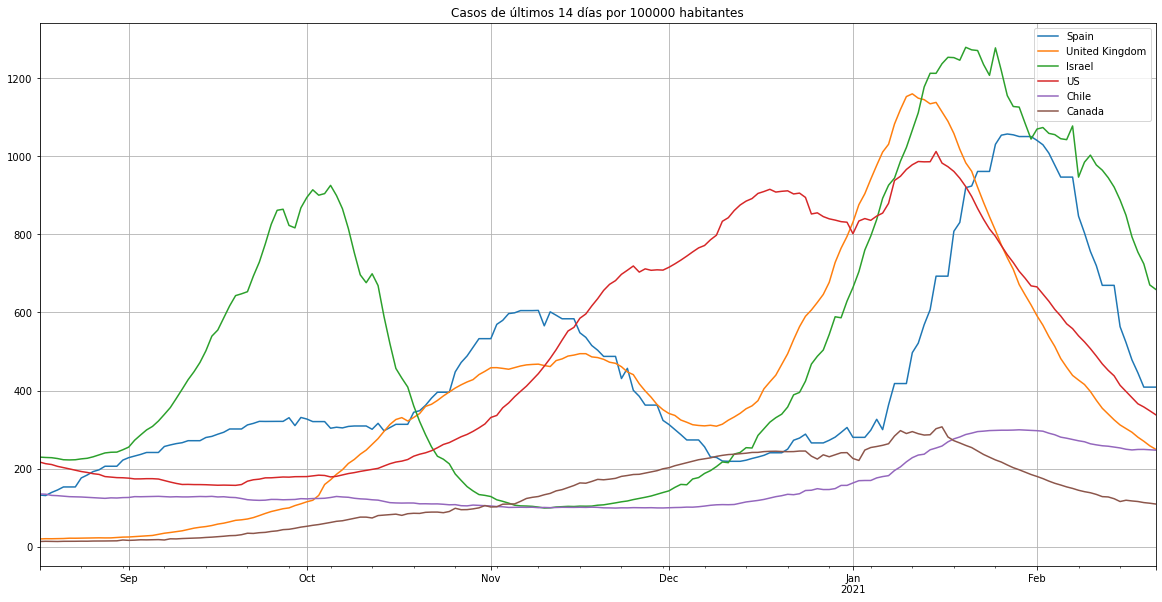

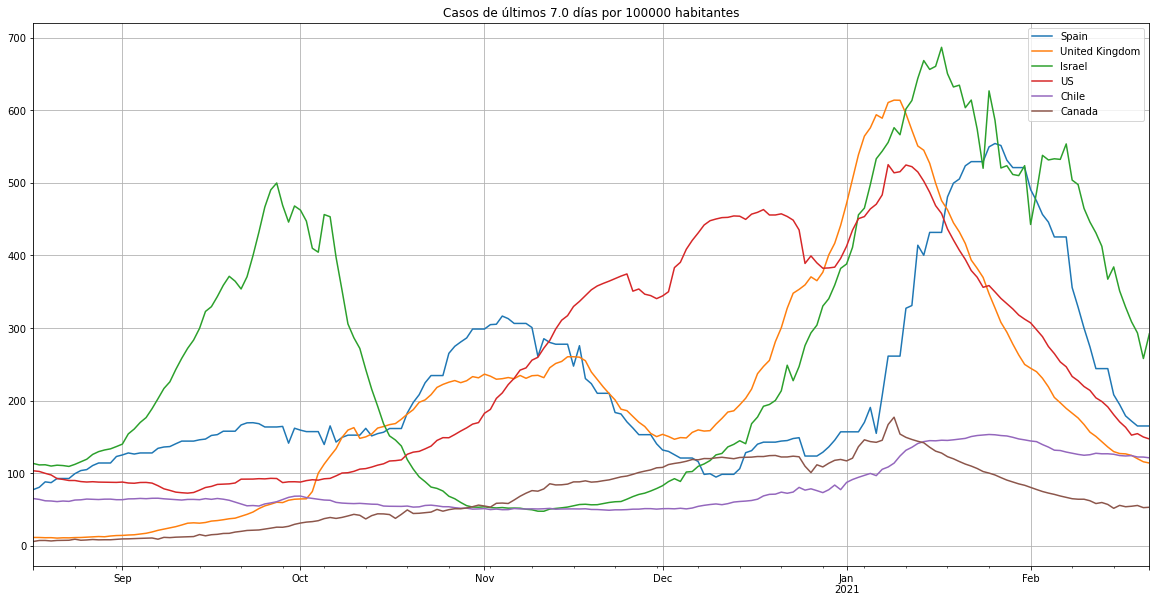

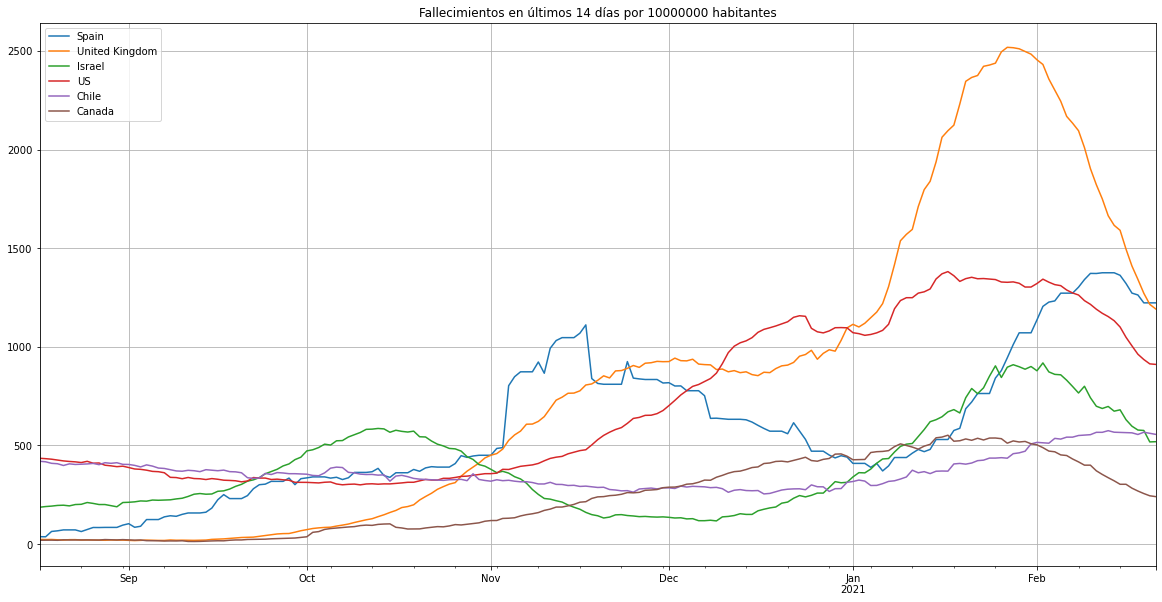

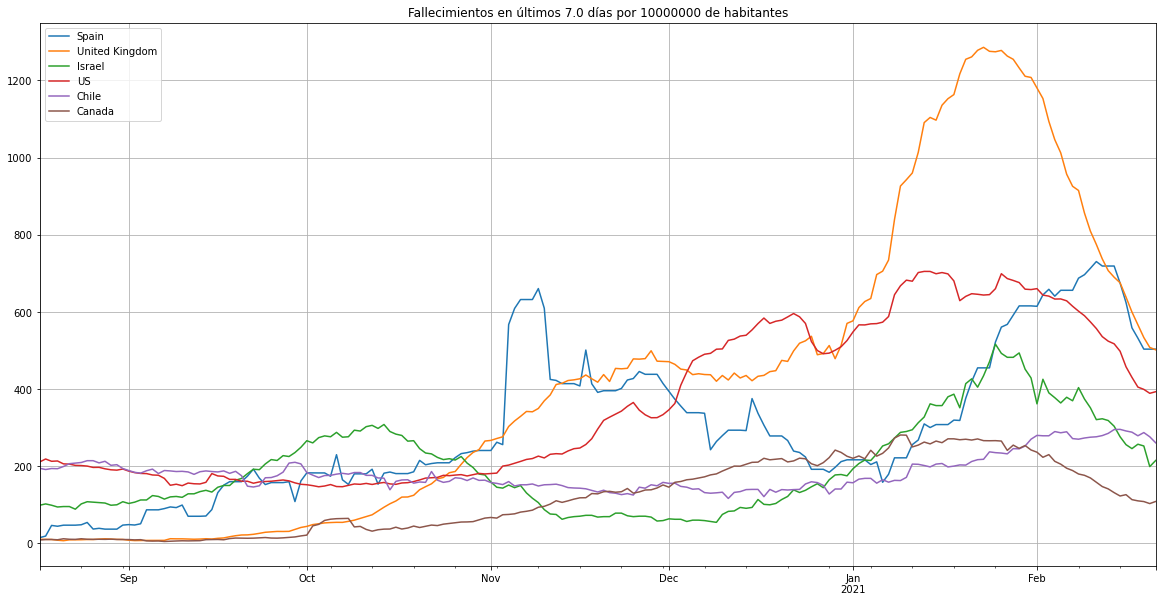

In [128]:
cw_df = confirmed_sum_by_pop_inc[fromdate_df:todate].rolling(min_periods=1, window=confirmed_window).sum()[interesting_countries]
cw_df[fromdate:todate].plot(
                            title='Casos de últimos {} días por {} habitantes'.format(confirmed_window, confirmed_factor), 
                            figsize=fsize, 
                            logy=logaritmic,
                            grid=True
                           )

cw2_df = confirmed_sum_by_pop_inc[fromdate_df:todate].rolling(min_periods=1, window=int(confirmed_window/2)).sum()[interesting_countries]
cw2_df[fromdate:todate].plot(
                             title='Casos de últimos {} días por {} habitantes'.format(confirmed_window/2, confirmed_factor), 
                             figsize=fsize, 
                             logy=logaritmic,
                             grid=True
                            )
dw_df = deaths_sum_by_pop_inc[fromdate_df:todate].rolling(min_periods=1, window=deaths_window).sum()[interesting_countries]
dw_df[fromdate:todate].plot(
                            title='Fallecimientos en últimos {} días por {} habitantes'.format(deaths_window, deaths_factor), 
                            figsize=fsize, 
                            logy=logaritmic,
                            grid=True
                           )
dw2_df = deaths_sum_by_pop_inc[fromdate_df:todate].rolling(min_periods=1, window=int(deaths_window/2)).sum()[interesting_countries]
dw2_df[fromdate:todate].plot(
                             title='Fallecimientos en últimos {} días por {} de habitantes'.format(deaths_window/2, deaths_factor), 
                             figsize=fsize, 
                             logy=logaritmic,
                             grid=True
                            )

Curvas de vacunación

<AxesSubplot:title={'center':'Vacunaciones (%)'}, xlabel='date'>

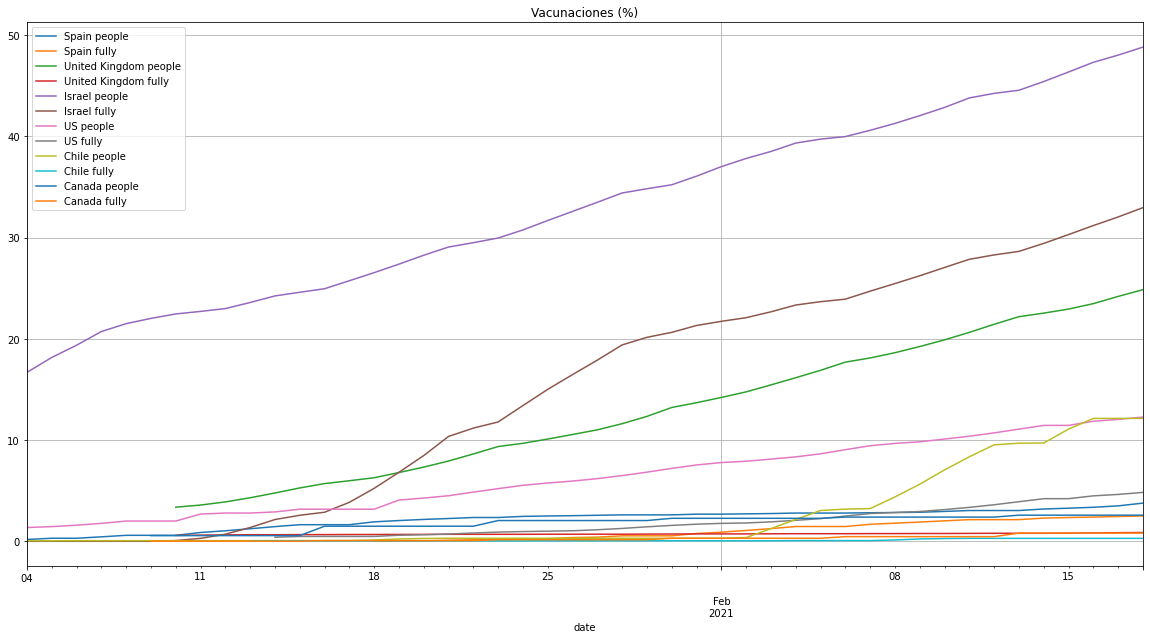

In [129]:
vac_grouped = vaccinations.groupby('location')

suffixes = {
    'people_vaccinated_per_hundred': ' people',
    'people_fully_vaccinated_per_hundred': ' fully'
}

# Utilizamos los nombres de países de la Johns Hopkins.
# Creamos, para ello, un diccionario que traduce el nombre del país en los datos
# de vacunaciones al nombre en los datos de la Johns Hopkins

change_vac_countries = {
    'US': 'United States'
}

change_vac_dict = {}
for k in change_vac_countries.keys():
    for suffix in suffixes.values():
        change_vac_dict[k + suffix] = change_vac_countries[k] + suffix

# Creamos un nuevo dataframe iterando sobre todos los países en grouped,
# añadiendo, para cada país, tantas columnas como líneas hay en el diccionario
# suffixes utilizando, en lugar del nombre de la clave, el del país seguido por
# el sufijo correspondiente.

vc_df = pd.DataFrame()
        

interesting_vac_renamed_countries = []
for country in interesting_countries:
    if country in change_vac_countries.keys():
        vcname = change_vac_countries[country]
    else:
        vcname = country
 
    if vcname in vac_grouped.groups:
        interesting_vac_renamed_countries.append((country,vcname))

        vacgr_df = vac_grouped.get_group(vcname).set_index('date')

        for item in suffixes.keys():
            vc_df[country + suffixes[item]] = vacgr_df[item]
        

vc_df.fillna(method='ffill',inplace=True)

#vc_df.fillna(0.0, inplace=True)

#vc_df [['Spain people', 'Spain fully']]

vc_labels = []
for i in interesting_vac_renamed_countries:
    for suffix in suffixes.values():
        vc_labels.append(i[0] + suffix)

vc_df_toplot = vc_df[vc_labels]
    
vc_df_toplot[fromdate:todate].plot(
                      title='Vacunaciones (%)', 
                      figsize=fsize, 
                      logy=logaritmic,
                      grid=True
                     )

Los siguientes gráficos muestran los casos confirmados y fallecimientos por cada país.

Los casos confirmados en las ventanas pequeñas son predictores de los casos confirmados en
ventanas más grandes y ambos son predictores del número de fallecimientos

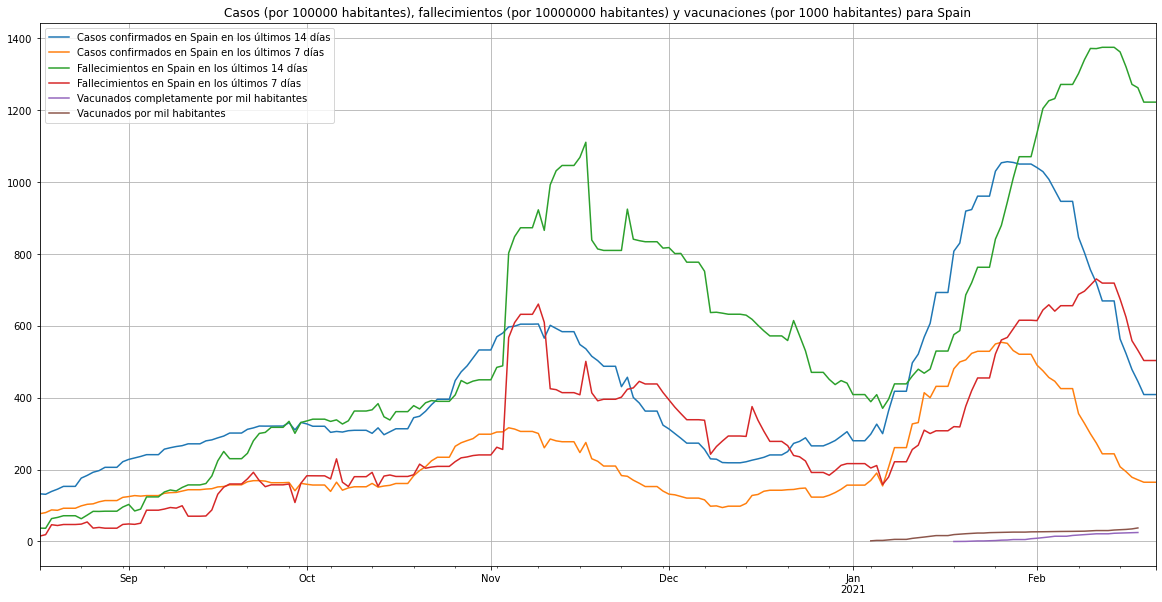

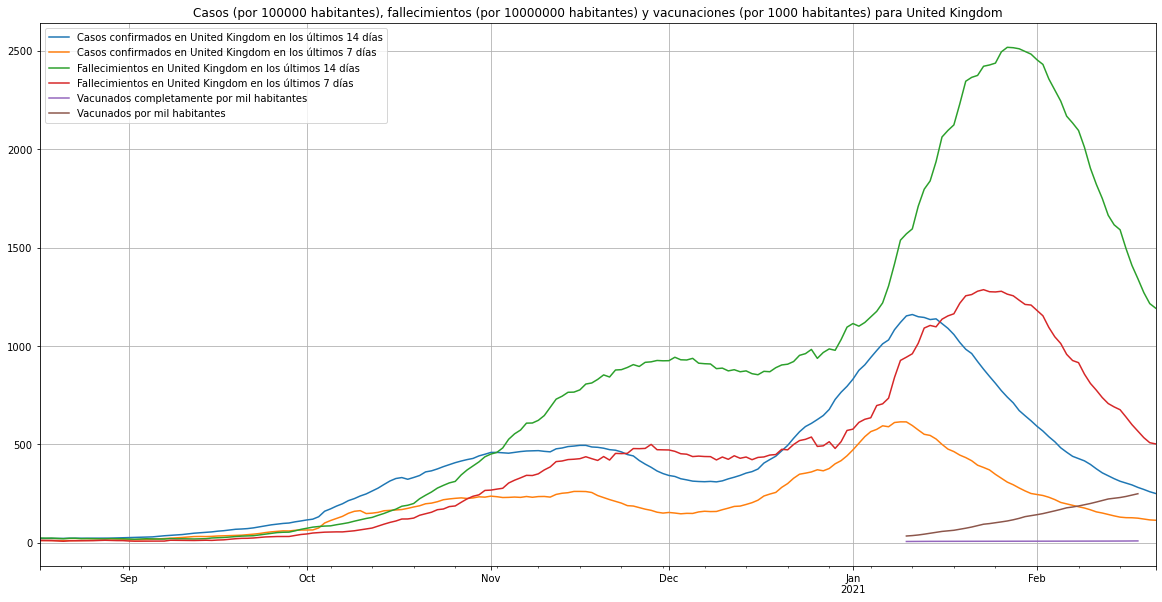

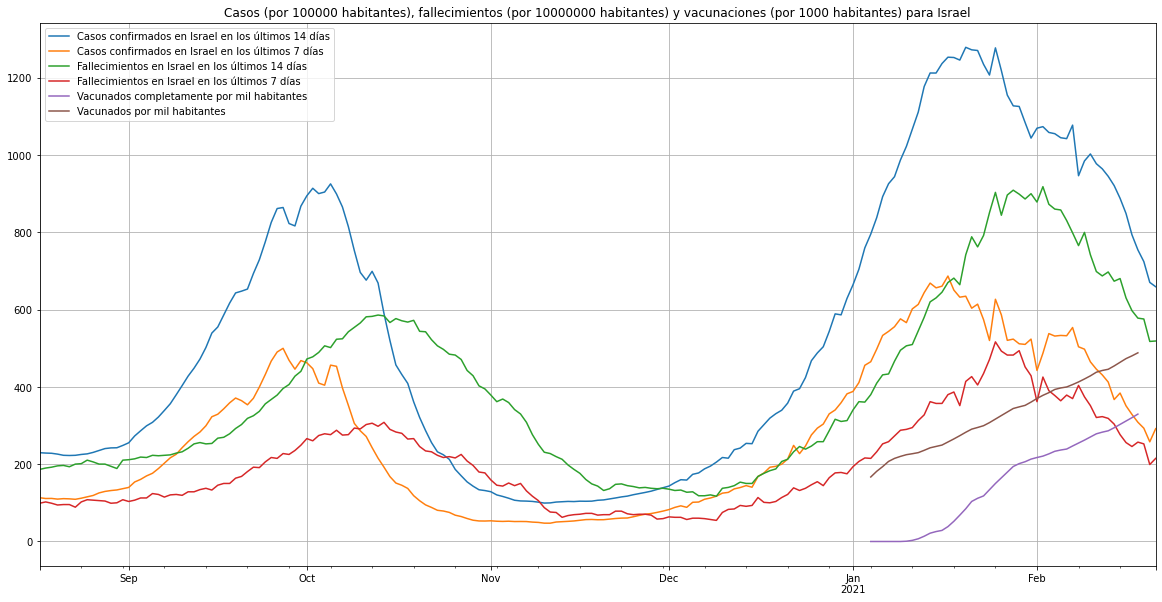

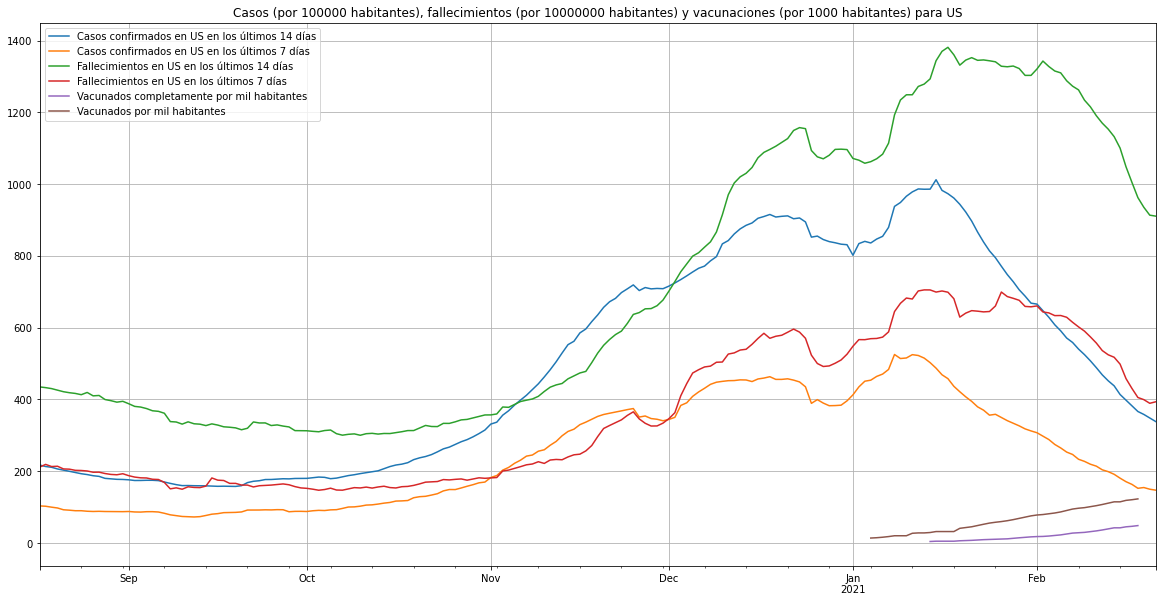

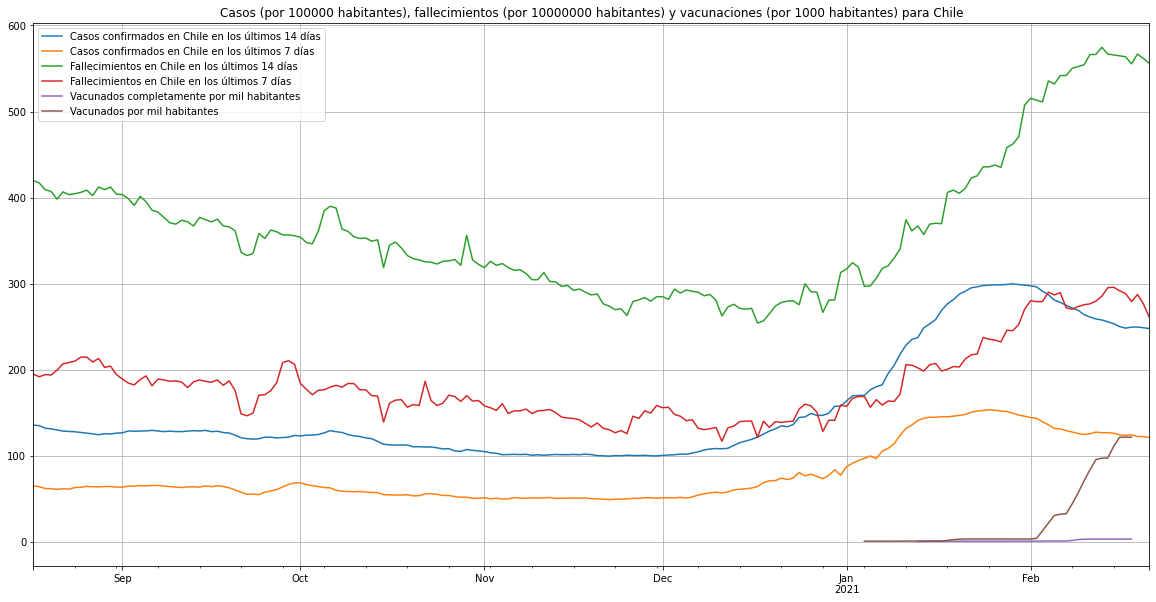

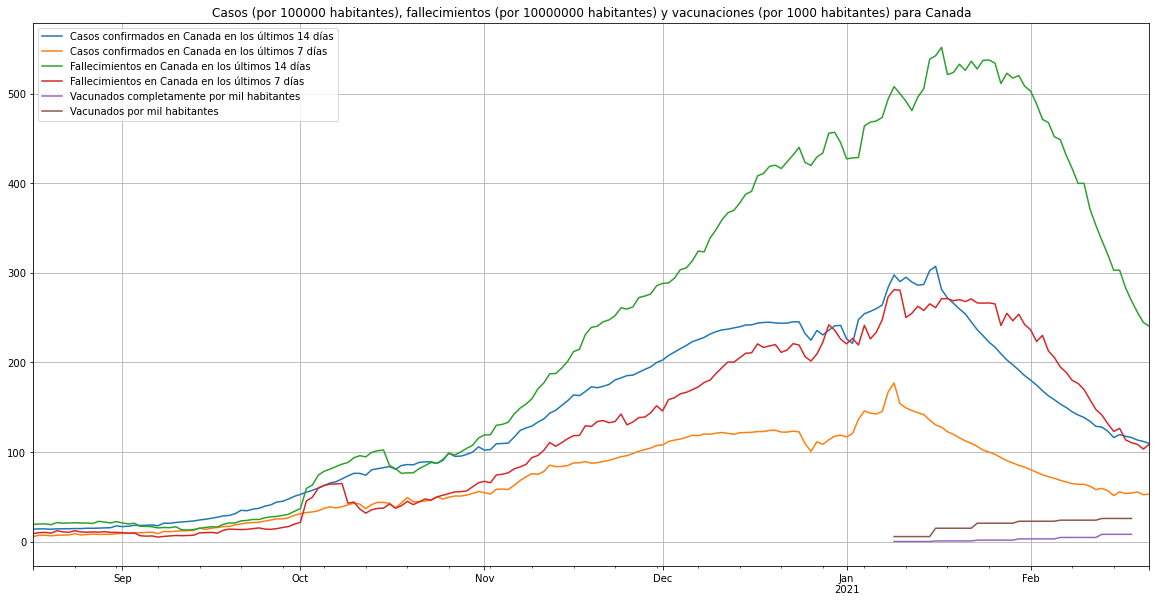

In [130]:
for ic in interesting_countries:
    country_df = pd.DataFrame()
    country_df['Casos confirmados en {} en los últimos {} días'.format(ic,str(confirmed_window))] = cw_df[ic]
    country_df['Casos confirmados en {} en los últimos {} días'.format(ic,str(int(confirmed_window/2)))] = cw2_df[ic]
    country_df['Fallecimientos en {} en los últimos {} días'.format(ic,str(confirmed_window))] = dw_df[ic]
    country_df['Fallecimientos en {} en los últimos {} días'.format(ic,str(int(confirmed_window/2)))] = dw2_df[ic]
    if ic + suffixes['people_fully_vaccinated_per_hundred'] in vc_df:
        country_df['Vacunados completamente por mil habitantes']= vc_df[ ic + suffixes['people_fully_vaccinated_per_hundred']]*10
    if ic + suffixes['people_vaccinated_per_hundred'] in vc_df:
        country_df['Vacunados por mil habitantes']= vc_df[ic + suffixes['people_vaccinated_per_hundred']]*10

    country_df[fromdate:todate].plot(
                   title='Casos (por {} habitantes), fallecimientos (por {} habitantes) y vacunaciones (por 1000 habitantes) para {}'.format(confirmed_factor, deaths_factor, ic), 
                                               figsize=fsize, 
                                               logy=logaritmic,
                                               grid=True
                                              )



In [131]:
first_date = dt.date(2020,3,1)
drange = pd.date_range(first_date,today)

msr_pd = pd.read_csv(data_dir + '/' + measures_file)
msr_pd = msr_pd[msr_pd['Country'] != 'Country']
msr_pd = msr_pd.fillna(today.strftime('%Y-%m-%d'))

msr_pd[['date_start', 'date_end']] = msr_pd[['date_start', 'date_end']].apply(pd.to_datetime)
msr_pd['Response_measure'] = msr_pd['Response_measure'].astype('category')

msr_countries = msr_pd['Country'].unique()
responses = msr_pd['Response_measure'].unique()

def is_between (d,first,last):
    return (d>=first) and (d <= last) 
        

msr_pc_pd = {}
# msr_prov = msr_pd[msr_pd['Country'] == 'Spain']
# msr_pc_pd['Spain'] = pd.DataFrame(index=drange, columns=responses).fillna(0)
for country in interesting_countries:
    if country in msr_countries:
        msr_prov = msr_pd[msr_pd['Country'] == country]
        msr_pc_pd[country] = pd.DataFrame(index=drange, columns=responses).fillna(0)
        for _,row in msr_prov.iterrows():
            for ix,_ in msr_pc_pd[country].iterrows():
                if is_between(ix,row['date_start'],row['date_end']):
                    msr_pc_pd[country].loc[ix][row['Response_measure']] = 1


<AxesSubplot:title={'center':'Número de medidas tomadas'}>

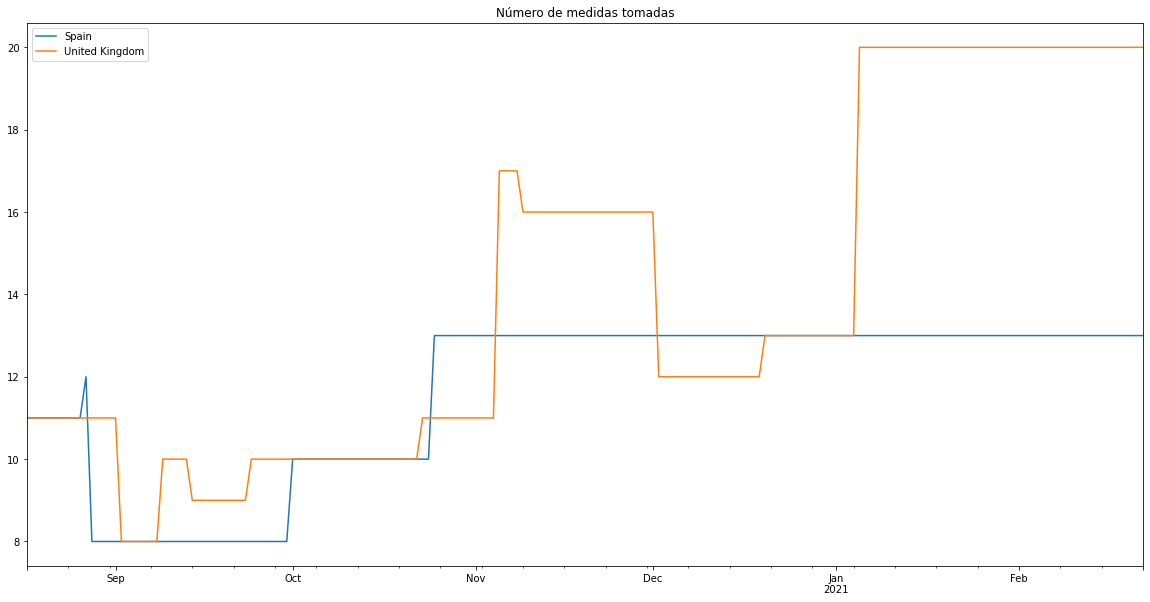

In [132]:
msr_plot_df = pd.DataFrame()
for country in interesting_countries:
    if country in msr_countries:
        msr_plot_df[country] = msr_pc_pd[country].sum(axis='columns')

msr_plot_df[fromdate:todate].plot(
    title='Número de medidas tomadas',
    figsize=fsize
)